    Candlestick Classifier
    
    What are candlesticks?
    
    Candlesticks are a visualization tool for trading in financial markets. They provide information about the open, low, high, and close prices over a set period. Since the invention of candlesticks in the 1800's Japanese candlestick patterns has been studied to make predictions about future price actions. Depending on the source there are between 30-100 recognized patterns with an association with the current market sentiment as well as some predictors about price. Candlestick patterns range in complexity and the nuance that typically takes an expert to identify quickly. 
    
    What is Image Classification?
    
    Image classification is a technique of assigning some class/label to an image. Machine learning/neural networks are a common way to train and implement a classification model. In this notebook, I will show how to create a simple classification model using TensorFlow and show its performance.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
!ls

Candle_Classifier.ipynb models
images                  testing_images


    The file structure is important when working with image classification as it is what determines the labels for each image. 
    
    I have 2 folders that contain images 1. images and 2. testing_images. The images folder contains subfolders of the classes I am to identify, in their respective subfolder are ~20 images per class that will be used for training and validation. In the testing_images folder, there are completely unseen images by the model that don’t contain any labels attached to them. Keeping a batch of images separate that can be used as an additional validation step is important to verify that the modeling process doesn't contain significant data leakage.

In [3]:
sample_arr = [] # add sample files for visualization of each patten trained

data_dir = 'images/'

for file in os.listdir(data_dir):
    if file == '.DS_Store': # ignore hidden file
        continue
    print(file)
    sample_arr.append((file, f"{data_dir}{file}/{os.listdir(f'{data_dir}{file}')[0]}")) # adding label and file path to list. Theres probably a better way to do this. TODO.

three_line_strike_bearish
evening_star_bearish
two_black_gapping_bearish
three_black_crows_bearish
morning_star_bullish
bullish_pin
three_line_strike_bullish
bearish_pin


    Visualizing each pattern that is in our samples.
    
    bullish and bearish sub-labels were added to be able to further help classify the sentiment/trend prediction.
    
    Bullish = Positive outlook, predicting an increase in price.
    
    Bearish = Negative outlook, predicting a decrease in price.
    
![](../visuals/candle_explaination.png)

    Other terms that are useful when describing candles are...
    
    Body - The section between the Open and Close price.
         - Green/White candles signify an increase in price from open to close
         - Red/Black candles signify a decrease in price from open to close
    
    Wick - The section between the High and Low prices and the body. 

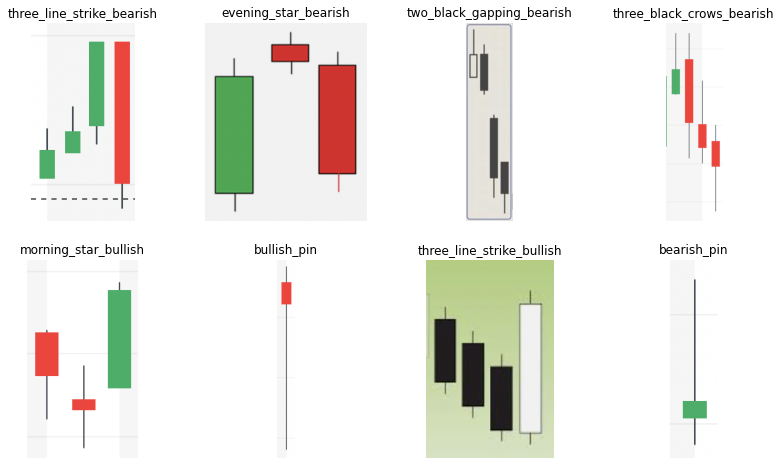

In [4]:
import matplotlib.image as mpimg

plt.figure(figsize=(14, 8))
for i, file in enumerate(sample_arr):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(file[1])
    imgplot = plt.imshow(img)
    plt.title(file[0])
    plt.axis("off")

    Pin - have a short body with long wicks. If the body is towards the top of the candle signifies a bullish sentiment and vice-versa. 
    
    Morning/evening star - a 3 candle pattern that has a gap between the close and open prices adjacent to the middle candle. The middle candle has a relatively small body. The direction of the third candle is what determines the direction of the new trend. 
    
    Three-line strike - a 4 candle pattern where the body of the 4th candle is longer than the previous 3 candles and moves in the opposite direction. 
    
    Two black gap - typically a 4 candle pattern where two bearish candles follow a reversal with a sizable gap between the 2nd and 3rd candle. 
    
    Three black crows - A reversal pattern that consists of 3 bearish candles where the 1st candle of the reversal has a longer body than the last bullish/green/white candle. The following candles have lower opens and closes than the previous candle.
    
    * These are brief descriptions of my interpretations of the patterns. 
    
    resources:
https://www.investopedia.com/trading/candlestick-charting-what-is-it/

https://en.wikipedia.org/wiki/Candlestick_pattern

https://www.alphaexcapital.com/candlestick-patterns/

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 134 files belonging to 8 classes.
Using 108 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 134 files belonging to 8 classes.
Using 26 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['bearish_pin',
 'bullish_pin',
 'evening_star_bearish',
 'morning_star_bullish',
 'three_black_crows_bearish',
 'three_line_strike_bearish',
 'three_line_strike_bullish',
 'two_black_gapping_bearish']

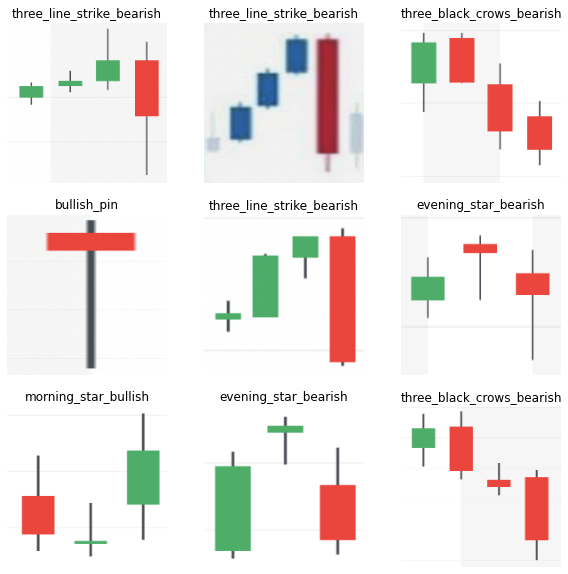

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) # casts the image to a ndarray for plotting
        plt.title(class_names[labels[i]])
        plt.axis("off")

```Dataset.cache``` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    
```Dataset.prefetch``` overlaps data preprocessing and model execution while training.
    
source: https://www.tensorflow.org/tutorials/images/classification

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1/255) # Images are in RBG scale, rescaling the data between 0 and 1 is best practice.

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.2392157 1.0


    Testing that the min and max values in the numpy array of the image are between 0 and 1.
    
    
    Model layers proposed as a standard approach from tensorflow. 

In [13]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1/255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

    Compiling the model based on an adam optimizer, training loss function determined by sparse categorical crossentropy and optimized for model accuracy. 
    
    *These parameters could potentially be tuned for better model performance.
    *Accuracy was determined to be the appropriate metric to optimize the model for based on business needs, as true postives and false negatives have similar problems in practice (ie. Not identifying a negative reversal of a stock you own and when you should exit, or predicitng an increase in price based of a false pattern).  

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 1s 115ms/step - loss: 4.9205 - accuracy: 0.1111 - val_loss: 2.0132 - val_accuracy: 0.1538
Epoch 2/10
4/4 [==============================] - 0s 37ms/step - loss: 2.1288 - accuracy: 0.2315 - val_loss: 1.9149 - val_accuracy: 0.4231
Epoch 3/10
4/4 [==============================] - 0s 42ms/step - loss: 1.8049 - accuracy: 0.4630 - val_loss: 1.7540 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 0s 37ms/step - loss: 1.5563 - accuracy: 0.6296 - val_loss: 1.4589 - val_accuracy: 0.5769
Epoch 5/10
4/4 [==============================] - 0s 36ms/step - loss: 1.1985 - accuracy: 0.7778 - val_loss: 1.1270 - val_accuracy: 0.6154
Epoch 6/10
4/4 [==============================] - 0s 42ms/step - loss: 0.8445 - accuracy: 0.7593 - val_loss: 0.7248 - val_accuracy: 0.8846
Epoch 7/10
4/4 [==============================] - 0s 52ms/step - loss: 0.4139 - accuracy: 0.9537 - val_loss: 0.5031 - val_accuracy: 0.9231
Epoch 8/10
4/4 [==========

    Plotting the modeling training to visualize the trends to insure that 1. Training/Validation Accuracy is increasing 2. Training/Validation Loss is decreasing

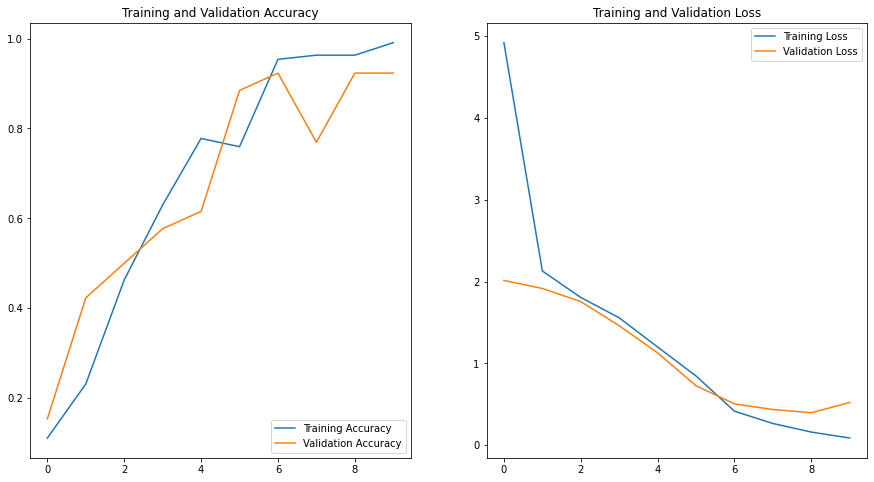

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

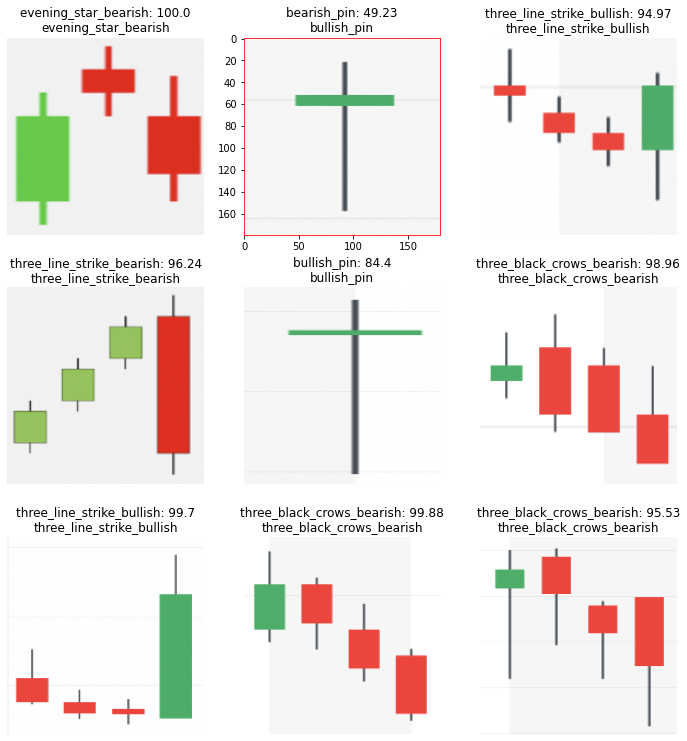

In [25]:
plt.figure(figsize=(12, 13))

for images, labels in val_ds.take(1):
    for i in range(9):
        img_array = tf.keras.utils.img_to_array(images[i])
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{class_names[np.argmax(score)]}: {round(100 * np.max(score), 2)}\n{class_names[labels[i]]}')
        if class_names[np.argmax(score)] == class_names[labels[i]]:
            plt.axis("off")
            plt.setp(ax.spines.values(), color='green')
        else:
            plt.setp(ax.spines.values(), color='red')
#         plt.axis("off")

In [19]:
from sklearn import metrics

y_true = []
y_pred = []

for images, labels in val_ds:
    for i in range(len(labels)):
        pred = model.predict(images)
        score = tf.nn.softmax(pred[i])
        classification = class_names[np.argmax(score)]

        actual = class_names[labels[i]]
        
        y_true.append(actual)
        y_pred.append(classification)

In [20]:
print(metrics.classification_report(y_pred, y_true))

                           precision    recall  f1-score   support

              bearish_pin       1.00      0.50      0.67         2
              bullish_pin       0.67      1.00      0.80         2
     evening_star_bearish       1.00      1.00      1.00         3
     morning_star_bullish       1.00      1.00      1.00         5
three_black_crows_bearish       1.00      1.00      1.00         5
three_line_strike_bearish       0.80      1.00      0.89         4
three_line_strike_bullish       1.00      0.80      0.89         5

                 accuracy                           0.92        26
                macro avg       0.92      0.90      0.89        26
             weighted avg       0.94      0.92      0.92        26



    Model accuracy = 0.92% (this ranges depending on training 0.88-0.92)
    
    *accuracy tested on 26 images, with 7 labels. More images could improve the accuracy and validation confidence.
    
    *model is determined to be sufficient proof of concept with useable results when classifying candlestick patterns with a reasonable amount of hand-labeled images.

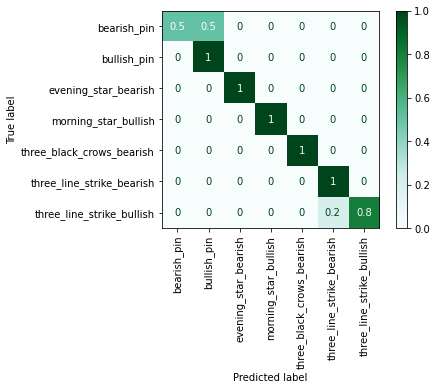

In [21]:
metrics.ConfusionMatrixDisplay.from_predictions(y_pred, y_true, xticks_rotation=90, cmap='BuGn', normalize='true')

    Testing model on unseen data.
    
    unlabeled images were added to 'testing_images/'. These were seperated from the training and validation batches to help evaluate if the model is over fitting on the data.

In [22]:
unseen_path = 'testing_images/'

unseen_images = tf.keras.utils.image_dataset_from_directory(
    unseen_path,
    image_size=(img_height, img_width))

Found 31 files belonging to 1 classes.


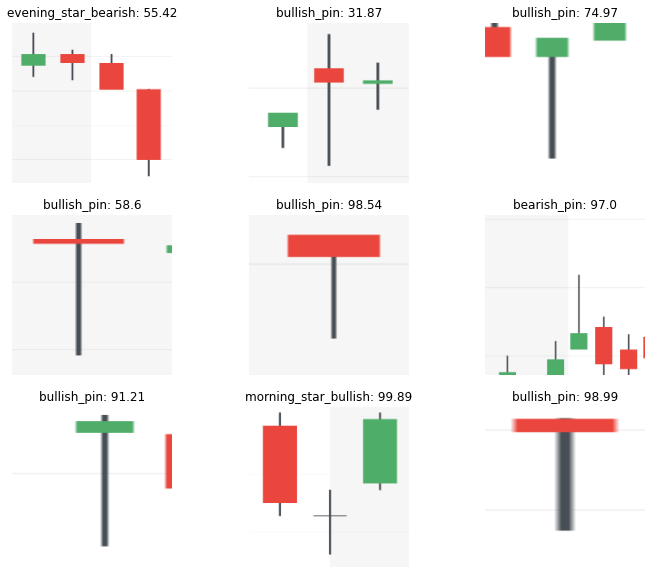

In [23]:
plt.figure(figsize=(12, 10))
for images, labels in unseen_images.take(1):
    for i in range(9):
        img_array = tf.keras.utils.img_to_array(images[i])
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{class_names[np.argmax(score)]}: {round(100 * np.max(score), 2)}')
        plt.axis("off")

    Double checking the model it appears to working properly on unseen data. The model can be saved for future use.

In [24]:
model.save('models/simple_model')

INFO:tensorflow:Assets written to: models/simple_model/assets
